In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Set paths
base_dir = '/content/drive/MyDrive/biotech/Retina_Lab/Image_data'
test_dir = os.path.join(base_dir, 'test')
model_path = os.path.join(base_dir, 'best_model.h5')

# Set parameters
img_width, img_height = 224, 224  # VGG16 expects 224x224 input
batch_size = 32


## Create Test Generator

In [ ]:
# Data generator for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Create test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Don't shuffle test data
)

# Get number of classes
num_classes = len(test_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Class indices: {test_generator.class_indices}")


Found 552 images belonging to 2 classes.
Number of classes: 2
Class indices: {'other': 0, 'pr': 1}


## Load the Model that has been previously trained

In [ ]:

# Try to load the complete model first
try:
    print("Attempting to load complete model...")
    model = load_model(model_path)
    print("Complete model loaded successfully!")
except Exception as e:
    print(f"Error loading complete model: {e}")
    print("Attempting to recreate model architecture and load weights...")

    # Recreate the model architecture
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

    # Freeze most of the layers
    for layer in base_model.layers[:-4]:  # Freeze all but the last 4 convolutional layers
        layer.trainable = False

    # Add custom classification layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
    x = Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Load weights
    model.load_weights(model_path)
    print("Model architecture recreated and weights loaded successfully!")


Attempting to load complete model...


Complete model loaded successfully!


## Test the Model

In [ ]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

# Get the class labels
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

# Function to display test images with predictions
def display_test_results(model, test_generator, class_labels, num_images=10):
    # Reset the generator to the beginning
    test_generator.reset()

    # Get batches of test images and make predictions
    all_images = []
    all_labels = []
    predictions = []

    # Collect images and predictions
    for i in range(min(int(np.ceil(num_images / batch_size)), int(np.ceil(test_generator.samples / batch_size)))):
        batch_images, batch_labels = next(test_generator)
        batch_predictions = model.predict(batch_images)

        all_images.extend(batch_images)
        all_labels.extend(batch_labels)
        predictions.extend(batch_predictions)

        if len(all_images) >= num_images:
            break

    # Display images with their true and predicted labels
    plt.figure(figsize=(15, int(num_images) * 2))

    for i in range(min(num_images, len(all_images))):
        # Get the image, true label, and prediction
        img = all_images[i]
        true_label_idx = np.argmax(all_labels[i])
        pred_label_idx = np.argmax(predictions[i])

        true_label = class_labels[true_label_idx]
        pred_label = class_labels[pred_label_idx]
        confidence = predictions[i][pred_label_idx] * 100

        # Create a row for each image
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(img)
        plt.title("Test Image")
        plt.axis('off')

        plt.subplot(num_images, 3, i*3 + 2)
        plt.text(0.5, 0.5, f"True: {true_label}",
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=14, color='blue')
        plt.axis('off')

        plt.subplot(num_images, 3, i*3 + 3)
        color = 'green' if pred_label == true_label else 'red'
        plt.text(0.5, 0.5, f"Prediction: {pred_label}\nConfidence: {confidence:.2f}%",
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=12, color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.9954 - loss: 0.0179
Test accuracy: 0.9928


## function to display confusion matrix

In [ ]:

# Generate and display confusion matrix
def evaluate_model_performance(model, test_generator):
    # Reset the generator to the beginning
    test_generator.reset()

    # Collect true labels and predictions
    y_true = []
    y_pred = []

    for i in range(int(np.ceil(test_generator.samples / batch_size))):
        batch_images, batch_labels = next(test_generator)
        batch_predictions = model.predict(batch_images)

        y_true.extend(np.argmax(batch_labels, axis=1))
        y_pred.extend(np.argmax(batch_predictions, axis=1))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(class_indices.keys())))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_indices))
    plt.xticks(tick_marks, class_indices.keys(), rotation=45)
    plt.yticks(tick_marks, class_indices.keys())

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Display predictions with images and model performance

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


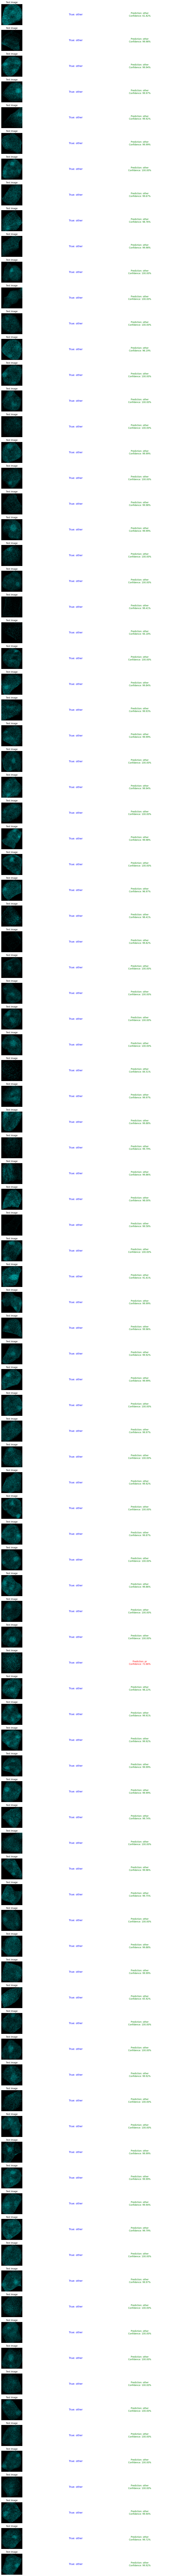

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step

Confusion Matrix:
[[160   1]
 [  3 388]]

Classification Report:
              precision    recall  f1-score   support

       other       0.98      0.99      0.99       161
          pr       1.00      0.99      0.99       391

    accuracy                           0.99       552
   macro avg  

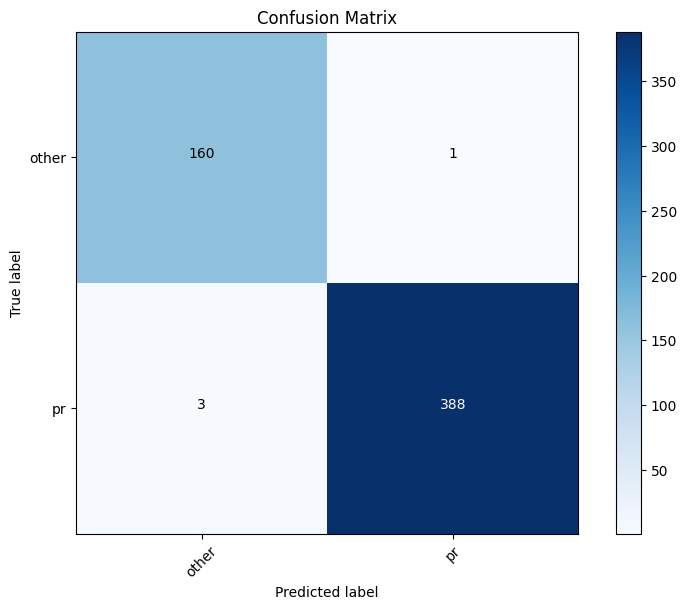

In [ ]:
# Display test images with predictions
display_test_results(model, test_generator, class_labels, num_images=10)

# Evaluate and display model performance
evaluate_model_performance(model, test_generator)